# Building a Quant Trading Strategy

## Building a ML Model in PyTorch

In [1]:
# DISCLAIMER: The method I used was inspired by a YouTube course. I studied and closely followed his approach, making some slight changes and applying it to different assets. 
# Our analysis will be done on ADAUSDT.
# I suggest you watch his YouTube channel, where he uses almost the same method but applied to BTCUSDT: 
# https://github.com/memlabs-research/build-a-quant-trading-strategy

In [2]:
# Trading strategy will be built in 3 parts:
# 1) Building the ML model: y_hat = model(x)
# 2) Orders = strategy(y_hat)
# 3) execute them (orders)

In [3]:
# The model will be a regression model => ADAUSDT => future log return
# It's going to be an AR model. 

In [4]:
# Data and analysis libraries
import polars as pl                         # Fast dataframes for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operations
import random


# Machine learning libraries  
import torch                                # PyTorch framework
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research                             # Local library of Model building and training utilities


# Visualization and 
import altair as alt                        # Interactive visualization library

# data sources
import binance                              # Local library of Binance market data utilities

In [5]:
# In machine learning, many processes involve randomness — such as splitting data, initializing weights, or shuffling batches. 
# To make sure the results are **reproducible** (i.e., the same every time you run the code), we set a fixed ”random seed.”
# Here, we use a utility function from the custom research module to set the seed to 42 (a common arbitrary choice). This ensures that:
# • Model training behaves consistently on each run.
# • Results and metrics are stable and debuggable.
research.set_seed(42)

In [6]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

polars.config.Config

In [7]:
# Trading pair symbol
sym = 'ADAUSDT'
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps 
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)
# Time window data (336 days)
hist_data_window = 7 * 4 * 6 * 2 

In [8]:
# Here we download raw historical trades
binance.download_trades(sym, hist_data_window)

In [9]:
# This loads and processes OHLCV candles into a clean time series format using the previously downloaded trades.
# The result is a Polars DataFrame (or similar structure) where each row represents a candle: Open, High, Low, Close, Volume for a given time interval (like 1h)
ts = research.load_ohlc_timeseries(sym, time_interval)
ts
# ts – This variable now holds the entire historical time series dataset, and printing it shows a preview of the structured price data.

Loading ADAUSDT: 100%|██████████████████████| 342/342 [00:09<00:00, 37.08file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0168,0.9964,1.0157
2024-11-28 01:00:00,1.0158,1.029,1.0106,1.0262
2024-11-28 02:00:00,1.0263,1.0321,1.0083,1.0112
2024-11-28 03:00:00,1.0111,1.0158,0.9882,1.0066
2024-11-28 04:00:00,1.0066,1.0272,1.0027,1.0149
…,…,…,…,…
2025-11-04 19:00:00,0.5242,0.5286,0.5132,0.5144
2025-11-04 20:00:00,0.5144,0.5162,0.4953,0.5101
2025-11-04 21:00:00,0.5102,0.5141,0.4894,0.5104


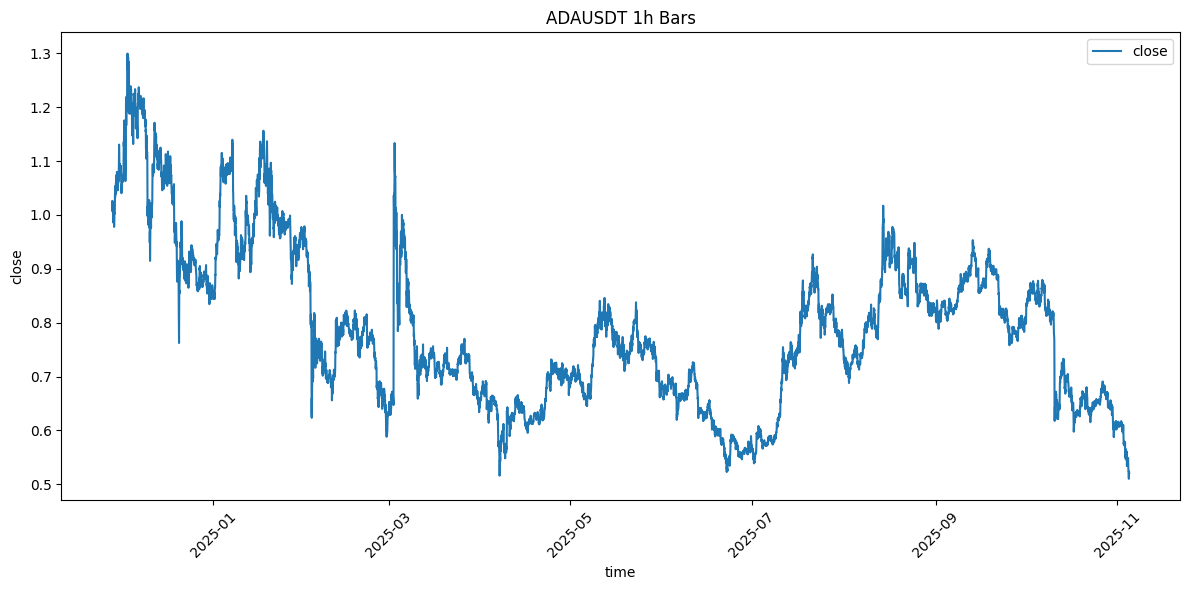

In [10]:
# Here we plot the timeseries
research.plot_static_timeseries(ts, sym, 'close', time_interval)

In [11]:
# Plotting the dynamic timeseries
alt.data_transformers.enable("vegafusion")
research.plot_dyn_timeseries(ts, sym, 'close', time_interval)

alt.Chart(...)

### Feature Engineering

### Creating target and lagged features

In [12]:
ts = ts.with_columns((pl.col('close')/pl.col('close').shift(forecast_horizon)).log().alias('close_log_return'))
ts

datetime,open,high,low,close,close_log_return
datetime[μs],f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0168,0.9964,1.0157,null
2024-11-28 01:00:00,1.0158,1.029,1.0106,1.0262,0.010285
2024-11-28 02:00:00,1.0263,1.0321,1.0083,1.0112,-0.014725
2024-11-28 03:00:00,1.0111,1.0158,0.9882,1.0066,-0.004559
2024-11-28 04:00:00,1.0066,1.0272,1.0027,1.0149,0.008212
…,…,…,…,…,…
2025-11-04 19:00:00,0.5242,0.5286,0.5132,0.5144,-0.019063
2025-11-04 20:00:00,0.5144,0.5162,0.4953,0.5101,-0.008394
2025-11-04 21:00:00,0.5102,0.5141,0.4894,0.5104,0.000588


In [13]:
target = 'close_log_return'
lr = pl.col(target)
ts = ts.with_columns(
    lr.shift(forecast_horizon * 1).alias(f'{target}_lag_1'),
    lr.shift(forecast_horizon * 2).alias(f'{target}_lag_2'),
    lr.shift(forecast_horizon * 3).alias(f'{target}_lag_3'),
    lr.shift(forecast_horizon * 4).alias(f'{target}_lag_4'),
)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0168,0.9964,1.0157,null,null,null,null,null
2024-11-28 01:00:00,1.0158,1.029,1.0106,1.0262,0.010285,null,null,null,null
2024-11-28 02:00:00,1.0263,1.0321,1.0083,1.0112,-0.014725,0.010285,null,null,null
2024-11-28 03:00:00,1.0111,1.0158,0.9882,1.0066,-0.004559,-0.014725,0.010285,null,null
2024-11-28 04:00:00,1.0066,1.0272,1.0027,1.0149,0.008212,-0.004559,-0.014725,0.010285,null
…,…,…,…,…,…,…,…,…,…
2025-11-04 19:00:00,0.5242,0.5286,0.5132,0.5144,-0.019063,-0.000191,-0.009867,-0.024066,-0.011728
2025-11-04 20:00:00,0.5144,0.5162,0.4953,0.5101,-0.008394,-0.019063,-0.000191,-0.009867,-0.024066
2025-11-04 21:00:00,0.5102,0.5141,0.4894,0.5104,0.000588,-0.008394,-0.019063,-0.000191,-0.009867


In [14]:
# We can also add the lags more easily using the following function from the local library
ts = research.add_lags(ts, target, max_lags, forecast_horizon)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0168,0.9964,1.0157,null,null,null,null,null
2024-11-28 01:00:00,1.0158,1.029,1.0106,1.0262,0.010285,null,null,null,null
2024-11-28 02:00:00,1.0263,1.0321,1.0083,1.0112,-0.014725,0.010285,null,null,null
2024-11-28 03:00:00,1.0111,1.0158,0.9882,1.0066,-0.004559,-0.014725,0.010285,null,null
2024-11-28 04:00:00,1.0066,1.0272,1.0027,1.0149,0.008212,-0.004559,-0.014725,0.010285,null
…,…,…,…,…,…,…,…,…,…
2025-11-04 19:00:00,0.5242,0.5286,0.5132,0.5144,-0.019063,-0.000191,-0.009867,-0.024066,-0.011728
2025-11-04 20:00:00,0.5144,0.5162,0.4953,0.5101,-0.008394,-0.019063,-0.000191,-0.009867,-0.024066
2025-11-04 21:00:00,0.5102,0.5141,0.4894,0.5104,0.000588,-0.008394,-0.019063,-0.000191,-0.009867


In [15]:
ts = ts.drop_nulls()

In [16]:
research.plot_distribution(ts, target, no_bins = 100)
# We can visually see how the distribution of the log returns looks like a normal distribution 

alt.Chart(...)

In [17]:
# meanwhile, we can see that the close price distribution doesn't have the same "good-looking" distribution.
research.plot_distribution(ts, 'close', no_bins = 100)

alt.Chart(...)

### Build Model

In [18]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)

### Complexity of the model

In [19]:
input_features = 1  # we try first with a AR(1) model 

linear_model = LinearModel(input_features)

research.print_model_info(linear_model, "Linear Model")
research.total_model_params(linear_model)


Linear Model

Architecture:
  LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

Parameter Count:
  Total parameters:      2
  Trainable parameters:  2



2

In [20]:
# the model is a very simple linear model that looks like --> y = w * x + b

### Split by time

In [21]:
# We now split the data into a training and testing set, using the correct approach for time series: a chronological split.
features = ['close_log_return_lag_1']
target = 'close_log_return'
test_size = 0.25

In [22]:
len(ts) # total number of samples

8203

In [23]:
int(len(ts) * test_size)  # number of test samples

2050

In [24]:
split_idx = int(len(ts) * (1-test_size))
split_idx # the index that separates training from testing

6152

In [25]:
ts_train, ts_test = ts[:split_idx], ts[split_idx:]

In [26]:
ts_train

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 05:00:00,1.0149,1.0179,1.002,1.0082,-0.006624,0.008212,-0.004559,-0.014725,0.010285
2024-11-28 06:00:00,1.0083,1.0136,1.0003,1.0055,-0.002682,-0.006624,0.008212,-0.004559,-0.014725
2024-11-28 07:00:00,1.0056,1.0124,0.9912,0.9972,-0.008289,-0.002682,-0.006624,0.008212,-0.004559
2024-11-28 08:00:00,0.9973,1.0042,0.9882,0.9978,0.000602,-0.008289,-0.002682,-0.006624,0.008212
2024-11-28 09:00:00,0.9979,0.9987,0.9851,0.9858,-0.012099,0.000602,-0.008289,-0.002682,-0.006624
…,…,…,…,…,…,…,…,…,…
2025-08-11 08:00:00,0.809,0.8204,0.8037,0.8165,0.009104,-0.019097,0.003523,-0.003401,-0.00097
2025-08-11 09:00:00,0.8164,0.82,0.8106,0.8132,-0.00405,0.009104,-0.019097,0.003523,-0.003401
2025-08-11 10:00:00,0.8132,0.8144,0.8055,0.8067,-0.008025,-0.00405,0.009104,-0.019097,0.003523


In [27]:
ts_test

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-11 13:00:00,0.7885,0.7972,0.7823,0.7941,0.007204,-0.002281,-0.020666,-0.008025,-0.00405
2025-08-11 14:00:00,0.7941,0.7994,0.7876,0.7899,-0.005303,0.007204,-0.002281,-0.020666,-0.008025
2025-08-11 15:00:00,0.79,0.7964,0.7862,0.7958,0.007442,-0.005303,0.007204,-0.002281,-0.020666
2025-08-11 16:00:00,0.7959,0.8044,0.791,0.7933,-0.003146,0.007442,-0.005303,0.007204,-0.002281
2025-08-11 17:00:00,0.7934,0.7972,0.7883,0.7902,-0.003915,-0.003146,0.007442,-0.005303,0.007204
…,…,…,…,…,…,…,…,…,…
2025-11-04 19:00:00,0.5242,0.5286,0.5132,0.5144,-0.019063,-0.000191,-0.009867,-0.024066,-0.011728
2025-11-04 20:00:00,0.5144,0.5162,0.4953,0.5101,-0.008394,-0.019063,-0.000191,-0.009867,-0.024066
2025-11-04 21:00:00,0.5102,0.5141,0.4894,0.5104,0.000588,-0.008394,-0.019063,-0.000191,-0.009867


### Converting Features and Targets to PyTorch Tensors

In [28]:
# Before training our model, we must convert the input features and target values into PyTorch tensors. 
# These tensors must be in the correct format: type float32 and shape [N, 1] for the targets.

In [29]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = ts_test[features].to_torch().float()
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [30]:
X_train

tensor([[ 0.0082],
        [-0.0066],
        [-0.0027],
        ...,
        [-0.0040],
        [-0.0080],
        [-0.0207]])

In [31]:
X_train.shape

torch.Size([6152, 1])

In [32]:
y_train

tensor([-0.0066, -0.0027, -0.0083,  ..., -0.0080, -0.0207, -0.0023])

In [33]:
y_train.shape

torch.Size([6152])

In [34]:
y_train = y_train.reshape(-1, 1)
y_train

tensor([[-0.0066],
        [-0.0027],
        [-0.0083],
        ...,
        [-0.0080],
        [-0.0207],
        [-0.0023]])

In [35]:
y_train.shape

torch.Size([6152, 1])

In [36]:
y_test = y_test.reshape(-1, 1)
y_test

tensor([[ 0.0072],
        [-0.0053],
        [ 0.0074],
        ...,
        [ 0.0006],
        [ 0.0253],
        [-0.0056]])

In [37]:
research.timeseries_train_test_split(ts, features, target, test_size)

(tensor([[ 0.0082],
         [-0.0066],
         [-0.0027],
         ...,
         [-0.0040],
         [-0.0080],
         [-0.0207]]),
 tensor([[-0.0023],
         [ 0.0072],
         [-0.0053],
         ...,
         [-0.0084],
         [ 0.0006],
         [ 0.0253]]),
 tensor([[-0.0066],
         [-0.0027],
         [-0.0083],
         ...,
         [-0.0080],
         [-0.0207],
         [-0.0023]]),
 tensor([[ 0.0072],
         [-0.0053],
         [ 0.0074],
         ...,
         [ 0.0006],
         [ 0.0253],
         [-0.0056]]))

### Batch Gradient Descent

In [38]:
# Now we train the linear model using the full training dataset with batch gradient descent. 
# We use the Adam optimizer and mean squared error (MSE) as the loss function.

In [39]:
# hyperparameters
no_epochs = 1000 * 5 # the number of training cycles through the dataset.
lr = 0.0005 # learning rate, which controls how much the model updates on each step.

# create model
model = LinearModel(len(features))
# loss function
criterion = nn.MSELoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr = lr)

print("\nTraining model...")

for epoch in range(no_epochs):
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)

    # backward pass
    optimizer.zero_grad()   # 1. clear old gradients
    loss.backward()         # 2. compute new gradients
    optimizer.step()        # 3. update weights

    # check for improvement
    train_loss = loss.item()

    # logging
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{no_epochs}], Loss: {train_loss:.6f}")

print("\nLearned parameters")

for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}:\n{param.data.numpy()}")

# Evaluation
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_loss = criterion(y_hat, y_test)
    print(f"\nTest Loss: {test_loss.item():.6f}, Train Loss: {train_loss:.6f}")
    


Training model...
Epoch [500/5000], Loss: 0.469155
Epoch [1000/5000], Loss: 0.234858
Epoch [1500/5000], Loss: 0.101928
Epoch [2000/5000], Loss: 0.036306
Epoch [2500/5000], Loss: 0.009890
Epoch [3000/5000], Loss: 0.001948
Epoch [3500/5000], Loss: 0.000349
Epoch [4000/5000], Loss: 0.000160
Epoch [4500/5000], Loss: 0.000148
Epoch [5000/5000], Loss: 0.000148

Learned parameters
linear.weight:
[[0.02842534]]
linear.bias:
[7.446609e-06]

Test Loss: 0.000082, Train Loss: 0.000148


### Test Trading Peformance and Equity Curve

In [40]:
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),
    'y': y_test.squeeze()
}).with_columns(
    (pl.col('y_hat').sign()==pl.col('y').sign()).alias('is_won'),
    pl.col('y_hat').sign().alias('signal'),
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve
f32,f32,bool,f32,f32,f32
-0.000057,0.007204,false,-1.0,-0.007204,-0.007204
0.000212,-0.005303,false,1.0,-0.005303,-0.012507
-0.000143,0.007442,false,-1.0,-0.007442,-0.019948
0.000219,-0.003146,false,1.0,-0.003146,-0.023095
-0.000082,-0.003915,true,-1.0,0.003915,-0.019179
…,…,…,…,…,…
0.000002,-0.019063,false,1.0,-0.019063,0.235201
-0.000534,-0.008394,true,-1.0,0.008394,0.243596
-0.000231,0.000588,false,-1.0,-0.000588,0.243008


In [41]:
research.plot_column(trade_results, 'equity_curve')

alt.Chart(...)

In [42]:
trade_results = trade_results.with_columns(
    (pl.col('equity_curve')-pl.col('equity_curve').cum_max()).alias('drawdown_log')
)
trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,drawdown_log
f32,f32,bool,f32,f32,f32,f32
-0.000057,0.007204,false,-1.0,-0.007204,-0.007204,0.0
0.000212,-0.005303,false,1.0,-0.005303,-0.012507,-0.005303
-0.000143,0.007442,false,-1.0,-0.007442,-0.019948,-0.012745
0.000219,-0.003146,false,1.0,-0.003146,-0.023095,-0.015891
-0.000082,-0.003915,true,-1.0,0.003915,-0.019179,-0.011976
…,…,…,…,…,…,…
0.000002,-0.019063,false,1.0,-0.019063,0.235201,-0.182134
-0.000534,-0.008394,true,-1.0,0.008394,0.243596,-0.173739
-0.000231,0.000588,false,-1.0,-0.000588,0.243008,-0.174327


In [43]:
max_drawdown_log = trade_results['drawdown_log'].min()
max_drawdown_log

-0.30574852228164673

In [44]:
# Max drawdown
drawdown_pct = np.exp(max_drawdown_log) - 1
drawdown_pct

np.float64(-0.2634281724301323)

In [45]:
equity_peak = 1000
equity_peak * drawdown_pct

np.float64(-263.4281724301323)

In [46]:
# Average win rate
win_rate = trade_results['is_won'].mean()
win_rate

0.47684056557776694

In [47]:
# Expected Value (EV) per Trade (our edge)
avg_win = trade_results.filter(pl.col('is_won')==True)['trade_log_return'].mean()
avg_loss = trade_results.filter(pl.col('is_won')==False)['trade_log_return'].mean()
ev = win_rate * avg_win + (1 - win_rate) * avg_loss
ev

0.00012813013415552757

In [48]:
total_log_return = trade_results['trade_log_return'].sum()
total_log_return

0.2627948522567749

In [49]:
# Total compund return
compound_return = np.exp(total_log_return)
compound_return

np.float64(1.3005598846571669)

In [50]:
1000*compound_return

np.float64(1300.5598846571668)

In [51]:
equity_trough = trade_results['equity_curve'].min()
equity_trough

-0.09150774031877518

In [52]:
# Equity peak
equity_peak = trade_results['equity_curve'].max()
equity_peak

0.4173353314399719

In [53]:
std = trade_results['trade_log_return'].std()
std

0.009094112552702427

In [54]:
# Sharpe 
sharpe = ev / std * annualized_rate
sharpe

np.float64(1.3186908993974922)

In [55]:
# To wrap it up in a single formula we can use the following one: 
research.eval_model_performance(y_test, y_hat, features, target, annualized_rate)

{'features': 'close_log_return_lag_1',
 'target': 'close_log_return',
 'no_trades': 2051,
 'win_rate': 0.47684056557776694,
 'avg_win': 0.006329889449514774,
 'avg_loss': -0.005524545178445911,
 'best_trade': 0.14803530275821686,
 'worst_trade': -0.05214012414216995,
 'ev': 0.00012813013415552757,
 'std': 0.009094112552702427,
 'total_log_return': 0.2627948522567749,
 'compound_return': np.float64(1.3005598846571669),
 'max_drawdown': -0.30574852228164673,
 'equity_trough': -0.09150774031877518,
 'equity_peak': 0.4173353314399719,
 'sharpe': np.float64(1.3186908993974908)}

In [56]:
target = 'close_log_return'
features = ['close_log_return_lag_2']
model = LinearModel(len(features))
perf = research.benchmark_reg_model(ts, features, target, model, annualized_rate, no_epochs=50)
perf

{'features': 'close_log_return_lag_2',
 'target': 'close_log_return',
 'no_trades': 2051,
 'win_rate': 0.5124329595319357,
 'avg_win': 0.0057115670269187145,
 'avg_loss': -0.0061156119128063435,
 'best_trade': 0.07705845683813095,
 'worst_trade': -0.14803530275821686,
 'ev': -5.497560580925093e-05,
 'std': 0.009094849228858948,
 'total_log_return': -0.1127549260854721,
 'compound_return': np.float64(0.8933695748686054),
 'max_drawdown': -0.5641617774963379,
 'equity_trough': -0.5068812966346741,
 'equity_peak': 0.057280465960502625,
 'sharpe': np.float64(-0.5657526189122183),
 'weights': '[-0.03685718]',
 'biases': '-0.00013825281348545104'}

In [57]:
import itertools

benchmarks = []
feature_pool = [f'{target}_lag_{i}' for i in range(1, max_lags + 1)]
combos = list(itertools.combinations(feature_pool, 1))

for features in combos:    
    model = LinearModel(len(features))
    benchmarks.append(research.benchmark_reg_model(ts, list(features), target, model, annualized_rate, test_size=test_size, no_epochs=200, loss=nn.L1Loss()))

benchmark = pl.DataFrame(benchmarks)
benchmark.sort('sharpe', descending=True)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",2051,0.496831,0.006224,-0.005597,0.148035,-0.05214,0.000276,0.009091,0.566953,1.762888,-0.338562,-0.239147,0.582378,2.845975,"""[-0.03173443]""","""-0.00015700937365181744"""
"""close_log_return_lag_4""","""close_log_return""",2051,0.510483,0.005985,-0.005828,0.148035,-0.077058,0.000202,0.009093,0.415024,1.514407,-0.279458,-0.254803,0.435399,2.082875,"""[0.00076238]""","""-0.00017382028454449028"""
"""close_log_return_lag_2""","""close_log_return""",2051,0.512433,0.005712,-0.006116,0.077058,-0.148035,-0.000055,0.009095,-0.112755,0.89337,-0.564162,-0.506881,0.05728,-0.565753,"""[-0.03709166]""","""-0.00013927696272730827"""
"""close_log_return_lag_1""","""close_log_return""",2051,0.50902,0.00557,-0.006259,0.05214,-0.148035,-0.000238,0.009092,-0.487827,0.613959,-0.600854,-0.524564,0.076289,-2.448486,"""[-0.06851022]""","""-0.00018055499822366983"""


In [58]:
research.auto_reg_corr_matrx(ts, target, max_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
f64,f64,f64,f64,f64
1.0,0.032504,-0.025332,-0.01589,0.015259
0.032504,1.0,0.032607,-0.025438,-0.015852
-0.025332,0.032607,1.0,0.032658,-0.025292
-0.01589,-0.025438,0.032658,1.0,0.032519
0.015259,-0.015852,-0.025292,0.032519,1.0


In [59]:
features = ['close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts, features, target, model, no_epochs=200, loss=nn.L1Loss())

research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

## Add Transaction Fees

In [60]:
maker_fee = 0.0001 # when you provide liquidity in the market, the fee is lower
taker_fee = 0.0003 # when you take out liquidity from the market, the fee is higher

# since we do 2 trades, we need to create a roundtrip fee
roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64
0.000098,0.007204,true,1.0,0.007204,0.007204,0.0,-0.0006,0.006604,0.006604
0.000501,-0.005303,false,1.0,-0.005303,0.001901,-0.005303,-0.0006,-0.005903,0.0007
-0.000085,0.007442,false,-1.0,-0.007442,-0.005541,-0.012745,-0.0006,-0.008042,-0.007341
-0.000387,-0.003146,true,-1.0,0.003146,-0.002394,-0.009598,-0.0006,0.002546,-0.004795
0.000011,-0.003915,false,1.0,-0.003915,-0.00631,-0.013514,-0.0006,-0.004516,-0.009311
…,…,…,…,…,…,…,…,…,…
0.000609,-0.019063,false,1.0,-0.019063,0.556149,-0.026229,-0.0006,-0.019663,-0.67242
0.000157,-0.008394,false,1.0,-0.008394,0.547754,-0.034624,-0.0006,-0.008995,-0.681415
-0.000152,0.000588,false,-1.0,-0.000588,0.547166,-0.035211,-0.0006,-0.001188,-0.682603


In [61]:
research.plot_column(model_trades, 'equity_curve_net')

alt.Chart(...)

In [62]:
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [63]:
# you can see that before adding the transaction fees, the model has a positive edge
# after adding rthe transaction fees, the model turns into a negative edge

In [64]:
model_trades['is_won'].mean()

0.4968308142369576

In [65]:
# we can also add the transaction fees using the following formula:
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
model_trades

y_pred,y_true,is_won,position,trade_log_return,equity_curve,drawdown_log_return,tx_fee_log,trade_log_return_net,equity_curve_net,trade_log_return_net_maker,trade_log_return_net_taker,equity_curve_net_maker,equity_curve_net_taker
f32,f32,bool,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
0.000098,0.007204,true,1.0,0.007204,0.007204,0.0,-0.0006,0.006604,0.006604,-9.203137,-8.104524,-9.203137,-8.104524
0.000501,-0.005303,false,1.0,-0.005303,0.001901,-0.005303,-0.0006,-0.005903,0.0007,-9.215643,-8.117031,-18.41878,-16.221555
-0.000085,0.007442,false,-1.0,-0.007442,-0.005541,-0.012745,-0.0006,-0.008042,-0.007341,-9.217782,-8.11917,-27.636562,-24.340725
-0.000387,-0.003146,true,-1.0,0.003146,-0.002394,-0.009598,-0.0006,0.002546,-0.004795,-9.207194,-8.108582,-36.843756,-32.449307
0.000011,-0.003915,false,1.0,-0.003915,-0.00631,-0.013514,-0.0006,-0.004516,-0.009311,-9.214256,-8.115643,-46.058012,-40.56495
…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.000609,-0.019063,false,1.0,-0.019063,0.556149,-0.026229,-0.0006,-0.019663,-0.67242,-9.229403,-8.130791,-18853.010593,-16604.151238
0.000157,-0.008394,false,1.0,-0.008394,0.547754,-0.034624,-0.0006,-0.008995,-0.681415,-9.218735,-8.120122,-18862.229328,-16612.271361
-0.000152,0.000588,false,-1.0,-0.000588,0.547166,-0.035211,-0.0006,-0.001188,-0.682603,-9.210928,-8.112316,-18871.440256,-16620.383677


In [66]:
# to lower the impact of the transaction fees, we must increase the time interval 
time_interval = '6h' # let's start by analyzing with 6h candles
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading ADAUSDT: 100%|██████████████████████| 342/342 [00:09<00:00, 35.47file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0321,0.9882,1.0082
2024-11-28 06:00:00,1.0083,1.0136,0.9822,0.9978
2024-11-28 12:00:00,0.9978,1.0108,0.9708,0.9991
2024-11-28 18:00:00,0.9991,1.05,0.9963,1.0328
2024-11-29 00:00:00,1.0328,1.0634,1.0283,1.0391
…,…,…,…,…
2025-11-03 18:00:00,0.5661,0.5671,0.5417,0.5526
2025-11-04 00:00:00,0.5526,0.563,0.5316,0.5339
2025-11-04 06:00:00,0.5339,0.5498,0.5302,0.5456


In [67]:
no_lags = 3
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0321,0.9882,1.0082,null,null,null,null
2024-11-28 06:00:00,1.0083,1.0136,0.9822,0.9978,-0.010369,null,null,null
2024-11-28 12:00:00,0.9978,1.0108,0.9708,0.9991,0.001302,-0.010369,null,null
2024-11-28 18:00:00,0.9991,1.05,0.9963,1.0328,0.033174,0.001302,-0.010369,null
2024-11-29 00:00:00,1.0328,1.0634,1.0283,1.0391,0.006081,0.033174,0.001302,-0.010369
…,…,…,…,…,…,…,…,…
2025-11-03 18:00:00,0.5661,0.5671,0.5417,0.5526,-0.02396,-0.016298,0.005228,-0.064287
2025-11-04 00:00:00,0.5526,0.563,0.5316,0.5339,-0.034426,-0.02396,-0.016298,0.005228
2025-11-04 06:00:00,0.5339,0.5498,0.5302,0.5456,0.021678,-0.034426,-0.02396,-0.016298


In [68]:
target = 'close_log_return'
feature_pool = [f'{target}_lag_{i}' for i in range(1, no_lags + 1)]
# To evaluate the predictive power of different feature sets, we use the built-in benchmarking function: 
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",341,0.539589,0.014865,-0.014285,0.203188,-0.10814,0.001444,0.023131,0.492326,1.636118,-0.253772,-0.230859,0.492326,5.841833,"""[-0.00618256]""","""-0.00026316303410567343"""
"""close_log_return_lag_1""","""close_log_return""",341,0.533724,0.014863,-0.014295,0.203188,-0.10814,0.001267,0.023142,0.432142,1.540554,-0.253772,-0.230859,0.432142,5.125399,"""[-0.00533875]""","""-0.00027974590193480253"""
"""close_log_return_lag_2""","""close_log_return""",341,0.545455,0.014262,-0.015001,0.095873,-0.203188,0.000961,0.023157,0.327587,1.387615,-0.205921,-0.185711,0.45688,3.882842,"""[-0.06400399]""","""-0.00027386436704546213"""


In [69]:
# This function:
# • Splits the time series into train/test sets (chronologically)
# • Trains the model on the training set using batch train reg()
# • Predicts on the test set
# • Evaluates performance using eval model performance()
# • Extracts model parameters (weights, bias)

In [70]:
# we can also visualize the correlation matrix and see that the highest correlation does not mean the best model
research.auto_reg_corr_matrx(ts.drop_nulls(), target, no_lags)

close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3
f64,f64,f64,f64
1.0,-0.002634,-0.06575,-0.004099
-0.002634,1.0,-0.002818,-0.065893
-0.06575,-0.002818,1.0,-0.002065
-0.004099,-0.065893,-0.002065,1.0


In [71]:
# now we visualize the benchmarks using different loss functions.

In [72]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",341,0.548387,0.015144,-0.013935,0.203188,-0.10814,0.002012,0.023089,0.685963,1.985682,-0.250669,-0.219754,0.685963,8.154483,"""[-0.00674914]""","""-0.0002591001393739134"""
"""close_log_return_lag_2""","""close_log_return""",341,0.545455,0.014262,-0.015001,0.095873,-0.203188,0.000961,0.023157,0.327587,1.387615,-0.205921,-0.185711,0.45688,3.882842,"""[-0.06400397]""","""-0.0002738641342148185"""
"""close_log_return_lag_1""","""close_log_return""",341,0.524927,0.013724,-0.015564,0.073183,-0.203188,-0.00019,0.023176,-0.064733,0.937318,-0.391867,-0.368954,0.022913,-0.766638,"""[-0.00599273]""","""-0.0002631022362038493"""


In [73]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, loss=nn.L1Loss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_3""","""close_log_return""",341,0.495601,0.015172,-0.014034,0.203188,-0.095873,0.00044,0.023172,0.150191,1.162057,-0.344033,-0.174875,0.494224,1.778986,"""[-0.06164247]""","""0.0003394107916392386"""
"""close_log_return_lag_2""","""close_log_return""",341,0.533724,0.013937,-0.015355,0.095873,-0.203188,0.000279,0.023175,0.095147,1.099821,-0.406348,-0.280773,0.202107,1.126876,"""[-0.0778007]""","""0.00024390978796873242"""
"""close_log_return_lag_1""","""close_log_return""",341,0.501466,0.014533,-0.014663,0.10814,-0.203188,-0.000022,0.023177,-0.007521,0.992507,-0.510531,-0.256141,0.254389,-0.089073,"""[-0.03731432]""","""0.00030068022897467017"""


In [75]:
# we plot the one with the highest sharpe-ratio
features = ['close_log_return_lag_3']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.MSELoss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [76]:
roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net_taker'))

research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

## Research 12 forecast horizon

In [77]:
time_interval = '12h'
ts = research.load_ohlc_timeseries(sym, time_interval)

Loading ADAUSDT: 100%|██████████████████████| 342/342 [00:09<00:00, 36.95file/s]


In [78]:
no_lags = 4
ts = research.add_log_return_features(ts, 'close', forecast_horizon, max_no_lags=no_lags)
ts

datetime,open,high,low,close,close_log_return,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_lag_4
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-11-28 00:00:00,1.0122,1.0321,0.9822,0.9978,null,null,null,null,null
2024-11-28 12:00:00,0.9978,1.05,0.9708,1.0328,0.034476,null,null,null,null
2024-11-29 00:00:00,1.0328,1.0883,1.0283,1.065,0.030701,0.034476,null,null,null
2024-11-29 12:00:00,1.0649,1.1008,1.0381,1.0762,0.010462,0.030701,0.034476,null,null
2024-11-30 00:00:00,1.0763,1.1516,1.0509,1.0953,0.017592,0.010462,0.030701,0.034476,null
…,…,…,…,…,…,…,…,…,…
2025-11-02 12:00:00,0.6138,0.6141,0.5917,0.6103,-0.005881,0.002446,0.000163,0.005897,-0.012408
2025-11-03 00:00:00,0.6103,0.612,0.566,0.5753,-0.059059,-0.005881,0.002446,0.000163,0.005897
2025-11-03 12:00:00,0.5754,0.5802,0.5244,0.5526,-0.040257,-0.059059,-0.005881,0.002446,0.000163


In [79]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.MSELoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",170,0.617647,0.023932,-0.020342,0.252487,-0.072273,0.007003,0.03393,1.190576,3.288975,-0.194106,-0.050628,1.384682,19.318649,"""[-0.15588976 -0.10544624]""","""-0.0008495963411405683"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.611765,0.024043,-0.020222,0.252487,-0.072273,0.006857,0.03396,1.165759,3.208358,-0.218922,-0.050628,1.384682,18.899267,"""[-0.15732324 -0.10606392 -0.0056672 ]""","""-0.00084784283535555"""
"""close_log_return_lag_2""","""close_log_return""",170,0.541176,0.024687,-0.02005,0.252487,-0.072273,0.00416,0.034397,0.707261,2.028428,-0.234884,-0.050628,0.766914,11.320339,"""[-0.08386971]""","""-0.0007333827670663595"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.541176,0.024453,-0.020326,0.252487,-0.072273,0.003908,0.034427,0.664301,1.943132,-0.280732,-0.050628,0.723954,10.623524,"""[-0.0817544 0.0105848]""","""-0.0007291270885616541"""
"""close_log_return_lag_1""","""close_log_return""",170,0.558824,0.021904,-0.02339,0.252487,-0.083599,0.001921,0.034596,0.32661,1.386261,-0.318134,-0.215098,0.644745,5.197686,"""[-0.14104776]""","""-0.0007726354524493217"""
"""close_log_return_lag_3""","""close_log_return""",170,0.488235,0.024942,-0.020286,0.252487,-0.111043,0.001796,0.034603,0.305251,1.356966,-0.284462,-0.264514,0.305251,4.856827,"""[0.02226627]""","""-0.000674157403409481"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",170,0.541176,0.022005,-0.023214,0.252487,-0.083599,0.001257,0.034626,0.213756,1.238321,-0.349978,-0.215098,0.563734,3.39871,"""[-0.14034721 0.01055477]""","""-0.0007635566289536655"""


In [80]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.HuberLoss())

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",170,0.611765,0.024043,-0.020222,0.252487,-0.072273,0.006857,0.03396,1.165759,3.208358,-0.218922,-0.050628,1.384682,18.899267,"""[-0.15612787 -0.10613843]""","""-0.0008385556866414845"""
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.611765,0.024043,-0.020222,0.252487,-0.072273,0.006857,0.03396,1.165759,3.208358,-0.218922,-0.050628,1.384682,18.899267,"""[-0.15646154 -0.10706232 -0.00591574]""","""-0.0008494661306031048"""
"""close_log_return_lag_2""","""close_log_return""",170,0.541176,0.024687,-0.02005,0.252487,-0.072273,0.00416,0.034397,0.707261,2.028428,-0.234884,-0.050628,0.766914,11.320339,"""[-0.0838697]""","""-0.0007333834655582905"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.541176,0.024453,-0.020326,0.252487,-0.072273,0.003908,0.034427,0.664301,1.943132,-0.280732,-0.050628,0.723954,10.623524,"""[-0.08150703 0.01084891]""","""-0.000723625416867435"""
"""close_log_return_lag_1""","""close_log_return""",170,0.558824,0.021904,-0.02339,0.252487,-0.083599,0.001921,0.034596,0.32661,1.386261,-0.318134,-0.215098,0.644745,5.197686,"""[-0.14101201]""","""-0.0007720430148765445"""
"""close_log_return_lag_3""","""close_log_return""",170,0.488235,0.024942,-0.020286,0.252487,-0.111043,0.001796,0.034603,0.305251,1.356966,-0.284462,-0.264514,0.305251,4.856827,"""[0.02208459]""","""-0.0006726952269673347"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",170,0.541176,0.022005,-0.023214,0.252487,-0.083599,0.001257,0.034626,0.213756,1.238321,-0.349978,-0.215098,0.563734,3.39871,"""[-0.14014369 0.0107037 ]""","""-0.0007671223720535636"""


In [81]:
research.benchmark_linear_models(ts.drop_nulls(), target, feature_pool, annualized_rate, max_no_features=3, loss=nn.L1Loss(), test_size=0.25)

features,target,no_trades,win_rate,avg_win,avg_loss,best_trade,worst_trade,ev,std,total_log_return,compound_return,max_drawdown,equity_trough,equity_peak,sharpe,weights,biases
str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.594118,0.023005,-0.021907,0.252487,-0.072273,0.004776,0.034317,0.811856,2.252084,-0.332007,-0.050628,1.143863,13.024953,"""[-0.11605211 -0.09810515 0.01127392]""","""-0.00018791056936606765"""
"""close_log_return_lag_1,close_log_return_lag_2""","""close_log_return""",170,0.594118,0.022877,-0.022095,0.252487,-0.072273,0.004623,0.034338,0.785982,2.194562,-0.38958,-0.050628,1.175563,12.602151,"""[-0.11127533 -0.10054048]""","""-0.0002729796105995774"""
"""close_log_return_lag_2""","""close_log_return""",170,0.535294,0.024547,-0.02027,0.252487,-0.072273,0.00372,0.034448,0.632388,1.882099,-0.229113,-0.050628,0.75391,10.107022,"""[-0.0808768]""","""-0.0004728947242256254"""
"""close_log_return_lag_3""","""close_log_return""",170,0.564706,0.023236,-0.021682,0.252487,-0.111043,0.003683,0.034452,0.626166,1.870425,-0.165992,-0.153669,0.626165,10.006426,"""[0.02608301]""","""-0.00012117849109927192"""
"""close_log_return_lag_2,close_log_return_lag_3""","""close_log_return""",170,0.517647,0.024387,-0.020597,0.252487,-0.073643,0.002689,0.034544,0.457099,1.579485,-0.301593,-0.050628,0.601101,7.285128,"""[-0.08619349 0.01644474]""","""-0.0003163381770718843"""
"""close_log_return_lag_1""","""close_log_return""",170,0.552941,0.022691,-0.022396,0.252487,-0.083599,0.002534,0.034556,0.430861,1.538582,-0.2182,-0.215098,0.604255,6.864626,"""[-0.11074901]""","""-0.0007010327535681427"""
"""close_log_return_lag_1,close_log_return_lag_3""","""close_log_return""",170,0.552941,0.022494,-0.02264,0.252487,-0.083599,0.002317,0.034571,0.393866,1.482702,-0.237226,-0.215098,0.625726,6.27242,"""[-0.1149921 0.00919041]""","""-0.0007054843590594828"""


### Save Best Model (Sharpe 19 Model)

In [82]:
features = ['close_log_return_lag_1','close_log_return_lag_2']
model = LinearModel(len(features))
model_trades = research.learn_model_trades(ts.drop_nulls(), features, target, model, loss=nn.MSELoss())
model_trades = research.add_tx_fees_log(model_trades, maker_fee, taker_fee)
research.plot_column(model_trades, 'equity_curve')

alt.Chart(...)

In [83]:
roundtrip_fee_log = np.log(1 - 2 * taker_fee)

model_trades = model_trades.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
model_trades = model_trades.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
model_trades = model_trades.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net_taker'))

research.plot_column(model_trades, 'equity_curve_net_taker')

alt.Chart(...)

In [84]:
# we save the model weights.
torch.save(model.state_dict(), 'model_weights.pth')